In [1]:
import multiprocessing
import shutil

import pandas as pd

from survey_medley_code.analysis_provenance import log_provenance
from survey_medley_code.config_loader import load_config
from survey_medley_code.outlier_detection_optimized import (
    generate_all_data_summaries_parallel,
)

## Outlier assessment
For this data set, I inspected the histograms and a threshold of 5 seemed better than the threshold of 8 we've used for other contrast estimates.

On second inspection, I've realize the questionnaire-averages that were unadjusted (other analysis) probably should also use a threhsold of 5.  I will repair that later so the anlayses match!

In [2]:
cfg = load_config()

data_root = (
    cfg.output_root
    / 'within_subject_adjusted_questionnaire_averages/within_subject_results'
)

In [4]:
# Get all subdirectories
all_dirs = [d for d in data_root.iterdir() if d.is_dir()]
subids = [d.name for d in all_dirs if d.name.isdigit() and len(d.name) == 3]
subids.sort()

contrast_names = [
    'brief',
    'upps',
    'grit',
    'future_time',
    'impulsive_venture',
]

In [6]:
dict_list = []

for contrast_name in contrast_names:
    print(contrast_name)
    subids_loop = []
    nifti_paths_loop = []
    for subid in subids:
        contrast_name = contrast_name
        pattern = f'{subid}/contrast_*{contrast_name}_effect_size_sub_{subid}.nii.gz'
        sub_nifti_paths = list(data_root.glob(pattern))
        if len(sub_nifti_paths) == 1:
            subids_loop.append(subid)
            nifti_paths_loop.append(sub_nifti_paths[0])
        else:
            print(f'sub {subid} had {len(sub_nifti_paths)} files for {contrast_name}')
    data_dict_loop = {
        'main_title': contrast_name,
        'nifti_paths': nifti_paths_loop,
        'image_labels': subids_loop,
        'data_type_label': 'contrast estimate',
    }
    dict_list.append(data_dict_loop)


brief
upps
grit
future_time
impulsive_venture


In [7]:
n_cpus = multiprocessing.cpu_count()
print(f'Detected {n_cpus} CPUs')

n_workers = min(n_cpus, 20)

Detected 24 CPUs


In [8]:
outlier_root = data_root / 'outlier_assessment'
shutil.rmtree(outlier_root, ignore_errors=True)
outlier_root.mkdir(parents=True, exist_ok=True)

this_notebook = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/analyses/within_subject_adjusted_questionnaire_averages/qa_outputs.ipynb'

log_provenance(outlier_root, settings={'notebook_file': this_notebook})

generate_all_data_summaries_parallel(
    dict_list, n_std=3, output_dir=outlier_root, n_workers=n_workers
)

Finished future_time
Finished impulsive_venture
Finished grit
Finished brief
Finished upps
PDF saved to /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_adjusted_questionnaire_averages/within_subject_results/outlier_assessment/outlier_analysis.pdf
All done! PDF saved to /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_adjusted_questionnaire_averages/within_subject_results/outlier_assessment/outlier_analysis.pdf


### I've looked at the pdf and we need to lower the cutoff for 5 with these data (previously we've used 8)

In [11]:
outlier_output = pd.read_csv(
    outlier_root / 'percent_outlier_data.csv', dtype={'subject_label': str}
)

In [13]:
for contrast, df_group in outlier_output.groupby('contrast_name'):
    # Save "good" subjects (< 5) to a text file
    good_subjects = df_group[df_group['image_outlier_percentage'] < 5]['subject_label']
    txt_path = outlier_root / f'subjects_outlier_percent_lt_5_contrast_{contrast}.txt'
    good_subjects.to_csv(txt_path, index=False, header=False)

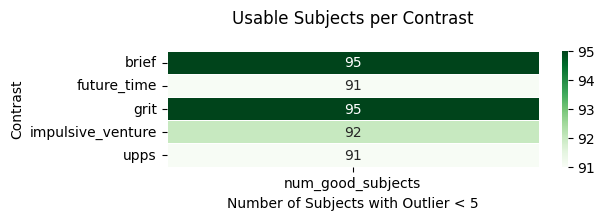

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute number of "good" subjects per contrast
usable_subjects = (
    outlier_output[outlier_output['image_outlier_percentage'] < 5]
    .groupby('contrast_name')['subject_label']
    .count()
    .reset_index(name='num_good_subjects')
)

# Pivot for heatmap format: y-axis = contrast, single column
heatmap_df = usable_subjects.set_index('contrast_name')

plt.figure(figsize=(6, len(heatmap_df) * 0.3))
ax = sns.heatmap(
    heatmap_df, annot=True, fmt='d', cmap='Greens', cbar=True, linewidths=0.5
)

ax.set_ylabel('Contrast')
ax.set_xlabel('Number of Subjects with Outlier < 5')
plt.title('Usable Subjects per Contrast', pad=20)
plt.show()